In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import blip_analysis as ba
import exp_blip_models as em
from sklearn.decomposition import PCA
from scipy.stats import poisson
from sklearn.cluster import OPTICS
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from tqdm import trange
from sklearn.metrics import confusion_matrix
from copy import deepcopy

b


In [2]:
usrt1, usrt2, usrt3 = ba.load_usrts()
good_indexes = ba.get_stable_resp_indexes()

Found odour 1
Found odour 3
Found odour 5


In [ ]:
diff_models1 = pickle.Unpickler(open('../Fig4/230320_diff_models1.pkl', 'rb')).load()
diff_models2 = pickle.Unpickler(open('../Fig4/230320_diff_models2.pkl', 'rb')).load()
diff_models3 = pickle.Unpickler(open('../Fig4/230320_diff_models3.pkl', 'rb')).load()

In [ ]:
[i.fit() for i in diff_models1];
[i.fit() for i in diff_models2];
[i.fit() for i in diff_models3];

In [ ]:
bin_weights1 = np.array([[j.x[:-1] for j in i.training_opts] for i in diff_models1])
bin_weights2 = np.array([[j.x[:-1] for j in i.training_opts] for i in diff_models2])
bin_weights3 = np.array([[j.x[:-1] for j in i.training_opts] for i in diff_models3])

In [ ]:
mean_weights1 = np.mean(bin_weights1, axis=1)
mean_weights2 = np.mean(bin_weights2, axis=1)
mean_weights3 = np.mean(bin_weights3, axis=1)


In [95]:
pca = PCA(n_components=9)
pcad_weights1 = pca.fit_transform(mean_weights1)
optics = OPTICS()
optics.fit(pcad_weights1[:, 1:3])
weights_1pc = deepcopy(pcad_weights1)
weights_1pc[:, 1:] = 0
weights_1pc = pca.inverse_transform(weights_1pc)

Text(0, 0.5, 'PC3')

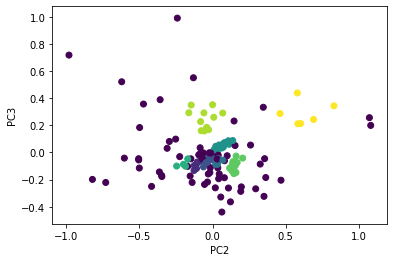

In [98]:
plt.scatter(pcad_weights1[:, 1], pcad_weights1[:, 2], c=optics.labels_)
plt.xlabel('PC2')
plt.ylabel('PC3')

Text(0, 0.5, 'PCs')

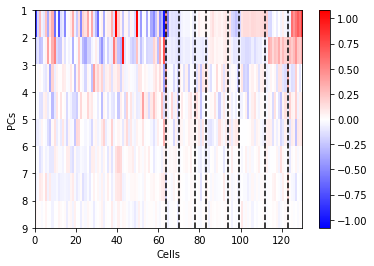

In [97]:
# for i in np.unique(optics.labels_):
#     plt.figure()
#     plt.imshow(pcad_weights1[:, 1:][optics.labels_ == i, :].T, aspect='auto')
 
#plt.imshow(pcad_weights1[:, 1:][optics.labels_ == 0, :].T, aspect='auto')
sorted_args = np.argsort(optics.labels_)
plt.figure()
vmax = np.max(abs(pcad_weights1[:, 1:]))
plt.imshow(pcad_weights1[sorted_args, 1:].T, aspect='auto', vmax=vmax, vmin=-vmax, cmap='bwr', extent=(0, 130, 9, 1))
for i in np.where(np.diff(optics.labels_[sorted_args]) != 0)[0]:
    plt.axvline(i, color='k', linestyle='--')
plt.colorbar()
plt.xlabel('Cells')
plt.ylabel('PCs')

In [ ]:
### Are these clusters from the same experiment?

recs = ba.load_recs()

In [104]:
unit_recording_index = []
for index, i in enumerate(recs.recordings):
    num_of_good_units = len(i.get_good_clusters())
    [unit_recording_index.append(index) for j in range(num_of_good_units)]
unit_recording_index = np.array(unit_recording_index)[good_indexes]

In [115]:
print(unit_recording_index[sorted_args])
print(np.max(optics.labels_))

[3 4 4 4 7 7 7 7 3 7 7 3 6 3 3 7 7 4 4 6 6 6 6 6 6 6 6 7 5 5 6 5 4 4 4 4 5
 3 6 3 0 0 7 0 0 0 0 1 1 3 1 1 1 1 1 1 1 2 2 7 3 2 7 7 2 1 1 0 2 6 4 7 0 2
 6 1 1 1 2 7 6 6 4 4 7 7 7 4 7 6 6 6 6 4 3 0 6 2 4 5 7 2 2 0 7 4 6 4 6 4 4
 4 6 3 3 7 7 7 3 7 3 3 7 5 6 3 7 3 6 3]
7


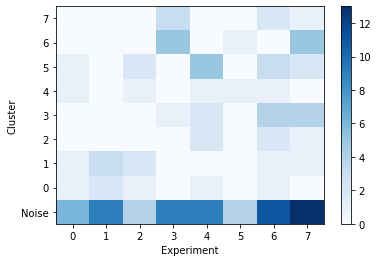

In [129]:
rec_cluster_counts = np.zeros((8, 9))
for i in range(130):
    rec_cluster_counts[unit_recording_index[i], optics.labels_[i]+1] += 1
plt.imshow(rec_cluster_counts.T, cmap='Blues', aspect='auto')
plt.yticks(range(9), labels=['Noise'] + list(range(8)))
plt.ylim(-0.5, 8.5)
plt.xlabel('Experiment')
plt.ylabel('Cluster')
plt.colorbar()

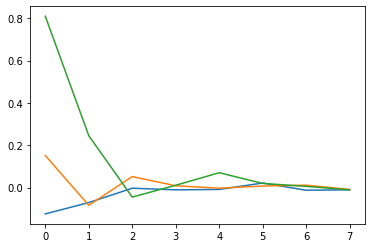

In [25]:
plt.plot(np.mean(pcad_weights1[:, 1:][optics.labels_ == 0, :], axis=0))
plt.plot(np.mean(pcad_weights1[:, 1:][optics.labels_ == 1, :], axis=0))
plt.plot(np.mean(pcad_weights1[:, 1:][optics.labels_ == 2, :], axis=0))

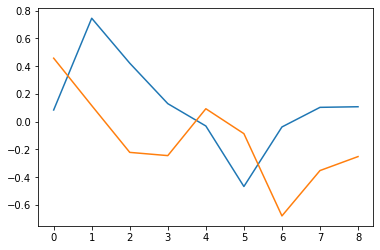

In [30]:
plt.plot(pca.components_[1])
plt.plot(pca.components_[2])

In [144]:
## Checking to see if the cells which are clustered as noise generate the same matrix with 1 or more pcs

def generate_poisson_data(base_data, number_of_reps=5):
    poisson_generated = np.array([[poisson(i).rvs(number_of_reps) for i in j] for j in base_data])
    return poisson_generated

diff_models_1pc = [deepcopy(i) for i in diff_models1]
thresholds = [i.opt_out.x[-1] for i in diff_models_1pc]
ws = [list(i) + [j] for i, j in zip(weights_1pc, thresholds)]
[i.fit(W=w) for i, w in zip(diff_models_1pc, ws)];

noise_residuals = [i.pred_resp for i in diff_models1[optics.labels_ == 3]]

noise_residuals_1pc = [i.pred_resp for i in np.array(diff_models_1pc)[optics.labels_ == -1]]
full_preds = [i.pred_resp for i in diff_models1]

noise_residuals_gen = generate_poisson_data(noise_residuals)
full_gen = generate_poisson_data(full_preds)
noise_residuals_1pc_gen = generate_poisson_data(noise_residuals_1pc)


In [147]:
def generate_cm(pred_resps, number_of_reps=5):
    generated_data = generate_poisson_data(pred_resps, number_of_reps=number_of_reps)
    ys = [i for i in range(32) for j in range(number_of_reps)]
    trues = []
    preds = []
    for i in trange(100, position=0):
        X_train, X_test, y_train, y_test = train_test_split(generated_data.reshape(len(generated_data), -1).T, ys, test_size=32, stratify=ys)
        rf = RandomForestClassifier()
        rf.fit(X_train, y_train)
        preds.append(rf.predict(X_test))
        trues.append(y_test)
    cm = confusion_matrix(np.concatenate(trues), np.concatenate(preds), normalize='true', labels=range(32))
    return cm

cms = []
for i in np.sort(np.unique(optics.labels_)):
    cm = generate_cm(np.array(full_preds)[optics.labels_ == i])
    cms.append(cm)
    print(i)


  0%|          | 0/100 [00:00<?, ?it/s]

-1


  0%|          | 0/100 [00:00<?, ?it/s]

0


  0%|          | 0/100 [00:00<?, ?it/s]

1


  0%|          | 0/100 [00:00<?, ?it/s]

2


  0%|          | 0/100 [00:00<?, ?it/s]

3


100%|██████████| 100/100 [00:12<00:00,  8.31it/s]


4


  0%|          | 0/100 [00:00<?, ?it/s]

5


  0%|          | 0/100 [00:00<?, ?it/s]

6


100%|██████████| 100/100 [00:11<00:00,  8.47it/s]

7


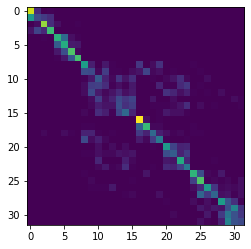

In [155]:
plt.imshow(cms[0])

In [145]:
ys = [i for i in range(32) for j in range(5)]
preds = []
trues = []
for i in trange(100, position=0, leave=True):
    X_train, X_test, y_train, y_test = train_test_split(noise_residuals_gen.reshape(len(noise_residuals_gen), -1).T, ys, test_size=32, stratify=ys)
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    preds.append(rf.predict(X_test))
    trues.append(y_test)

100%|██████████| 100/100 [00:12<00:00,  8.32it/s]


In [61]:
ys = [i for i in range(32) for j in range(5)]
preds_full = []
trues_full = []
for i in trange(100, position=0, leave=True):
    X_train, X_test, y_train, y_test = train_test_split(full_gen.reshape(130, -1).T, ys, test_size=32, stratify=ys)
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    preds_full.append(rf.predict(X_test))
    trues_full.append(y_test)

100%|██████████| 100/100 [00:16<00:00,  6.05it/s]


In [71]:
ys = [i for i in range(32) for j in range(5)]
preds_1pc = []
trues_1pc = []
for i in trange(100, position=0, leave=True):
    X_train, X_test, y_train, y_test = train_test_split(noise_residuals_1pc_gen.reshape(108, -1).T, ys, test_size=32, stratify=ys)
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    preds_1pc.append(rf.predict(X_test))
    trues_1pc.append(y_test)

100%|██████████| 100/100 [00:15<00:00,  6.42it/s]


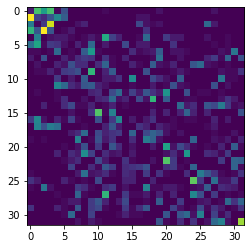

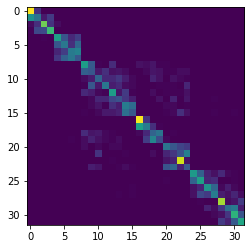

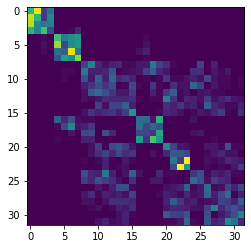

In [146]:
cm = confusion_matrix(np.concatenate(trues), np.concatenate(preds), labels=range(32), normalize='true')
plt.imshow(cm)
plt.figure()
cm_full = confusion_matrix(np.concatenate(trues_full), np.concatenate(preds_full), labels=range(32), normalize='true')
plt.imshow(cm_full)
plt.figure()
cm_1pc = confusion_matrix(np.concatenate(trues_1pc), np.concatenate(preds_1pc), labels=range(32), normalize='true')
plt.imshow(cm_1pc)

In [55]:
print(np.corrcoef(cm.ravel(), cm_full.ravel()))

[[1.         0.87346632]
 [0.87346632 1.        ]]
